In [ ]:
import torch
from torch import Tensor
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import List, Dict
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPFeatureExtractor, CLIPTextModel
from argparse import Namespace
import random
from tqdm.auto import tqdm
import math
import wandb
import os
import itertools
import datetime
import pytz
import PIL
import json
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tensor2pil = transforms.ToPILImage()
wandb.login()

### Select images to share on the Hub

In [ ]:
ARTIFACT_NAME = 'inference_artifact_2023-01-11_21-38-22'

with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=False) as run:
    artifact = run.use_artifact(f'{ARTIFACT_NAME}:latest')

datadir = artifact.download()

json_path = f'artifacts/{ARTIFACT_NAME}:v0/inference_table.table.json'
json_content = json.load(open(json_path))

for i, sample in enumerate(json_content['data']):
    image_path = f'artifacts/{ARTIFACT_NAME}:v0/' + sample[0]['path']
    print(f'Image ID: {i}')
    display(PIL.Image.open(image_path).resize((256, 256)))
    print()

In [ ]:
PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'

selected_prompts_and_images = {
    'spiderman': ['inference_artifact_2023-01-11_21-38-22', [3, 5, 6, 14]],
    'painting': ['inference_artifact_2023-01-11_21-32-10', [0, 2, 4, 8]],
    'futuristic': ['inference_artifact_2023-01-14_13-58-37', [1, 2, 12, 15]],
    'cinema': ['inference_artifact_2023-01-11_22-04-51', [3, 7, 13, 15]],
    'punk': ['inference_artifact_2023-01-11_21-48-29', [2, 5, 12, 14]]
}

all_grids = []

for key, value in selected_prompts_and_images.items():    
    images = []
    seeds = []
    ARTIFACT_NAME, IDXS = value

    
    with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=False) as run:
        artifact = run.use_artifact(f'{ARTIFACT_NAME}:latest')
    
    datadir = artifact.download()
    
    json_path = f'artifacts/{ARTIFACT_NAME}:v0/inference_table.table.json'
    json_content = json.load(open(json_path))

    for i, sample in enumerate(json_content['data']):
        if i in IDXS:
            image_path = f'artifacts/{ARTIFACT_NAME}:v0/' + sample[0]['path']
            images.append(PIL.Image.open(image_path))
            seeds.append(json_content['data'][i][-1])

    example_grid = image_grid(images, rows=1, cols=4)
    all_grids.append(example_grid)
    
    columns_name = json_content['columns']
    for col, value in zip(columns_name, json_content['data'][0]):
        if col not in ['image', 'seed']:
            print(f'{col}: {value}')
    print(f'seed: {seeds}')
    display(example_grid)

In [ ]:
prompt = "an illustration of krts person sitting in a movie theater eating popcorn watching a movie, unreal engine, cozy indoor lighting, artstation, detailed, digital painting, cinematic, character design by mark ryden and pixar and hayao miyazaki, unreal 5, daz, hyperrealistic, octane render"
negative_prompt = 'low contrast, blurry, low resolution, warped'
guidance_scale = 7
inference_steps = 50
seed = 121111

generator = torch.Generator(device=device).manual_seed(seed)
image = pipeline(prompt,
                  negative_prompt=negative_prompt,
                  guidance_scale=guidance_scale,
                  height=512,
                  width=512,
                  num_inference_steps=50,
                  generator=generator
                 ).images[0]

display(image)

In [ ]:
grid_artifact = wandb.Artifact('hub_examples', type='hub_examples') 
for image in all_grids:
    grid_artifact.add(wandb.Image(image), 'kratos')

with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    run.log_artifact(grid_artifact)

In [ ]:
PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'
ARTIFACT_NAME = 'inference_artifact_2023-01-11_22-06-25'

with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=False) as run:
    artifact = run.use_artifact(f'{ARTIFACT_NAME}:latest')
    
# table = artifact.get("inference_artifact_2023-01-11_21-38-22")
datadir = artifact.download()

In [ ]:
from pathlib import Path

image_dir = Path(f'artifacts/{ARTIFACT_NAME}:v0/media/images')
images = [PIL.Image.open(image_path).resize((256, 256)) for image_path in list(image_dir.glob('*.png'))]

example_grid = image_grid(images, rows=1, cols=16)
example_grid

In [ ]:
image_dir = Path(f'artifacts/{ARTIFACT_NAME}:v0/media/images')
idxs = [6, 7, 8, 11]
images = []

for i, image_path in enumerate(list(image_dir.glob('*.png'))):
    if i in idxs:
        images.append(PIL.Image.open(image_path))

example_grid = image_grid(images, rows=1, cols=16)
example_grid

In [ ]:
# initialize WANDB artficat and table
examples_artifact = wandb.Artifact('hub_examples', type='hub_examples') 
examples_artifact.add(wandb.Image(example_grid), 'kratos')

# with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
#     run.log_artifact(examples_artifact)

In [ ]:
with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    run.log_artifact(examples_artifact)

In [ ]:
PROJECT_NAME = 'dreambooth-kratos'
RUN_ID = 'ay51iqly'
ARTIFACT_NAME = 'hub_examples'

with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=False) as run:
    artifact = run.use_artifact(f'{ARTIFACT_NAME}:latest')
    
# table = artifact.get("inference_artifact_2023-01-11_21-38-22")
datadir = artifact.download()

### Test model from the Hub

In [ ]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained('matteopilotto/kratos-sd-v1-4-dreambooth')
image = pipeline().images[0]
image

In [3]:
import torch
from diffusers import StableDiffusionPipeline

# set device-agnostic code
device = (
    'mps' if torch.backends.mps.is_available()
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)

# load pre-trained model
pretrained_ckpt = 'matteopilotto/kratos-sd-v1-4-dreambooth'
pipeline = StableDiffusionPipeline.from_pretrained(pretrained_ckpt).to(device)

# stable diffusion hyperparameters
unique_token = 'krts'
class_type = 'person'
prompt = f'An illustration of {unique_token} {class_type} punk playing electric guitar, tristan eaton, victo ngai, artgerm, rhads, ross draws'
negative_prompt = 'low contrast, blurry, low resolution, warped'
guidance_scale = 7
h = 512
w = 512
inference_steps = 50
seed = 594109

# set generator for reproducibility
generator = torch.Generator(device=device).manual_seed(seed)

# generate image
image = pipeline(
    prompt,
    negative_prompt=negative_prompt,
    guidance_scale=guidance_scale,
    height=h,
    width=w,
    num_inference_steps=inference_steps,
    generator=generator
).images[0]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

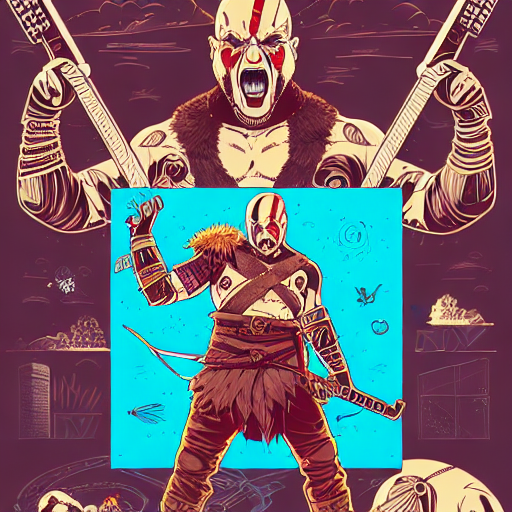

In [4]:
display(image)